<a href="https://colab.research.google.com/github/tram-tr/predicting-molecular-properties/blob/main/models_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# need authorization code to mount drive
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle


In [2]:
!pip install kaggle
!kaggle competitions download -c champs-scalar-coupling
!pip install ase

 99% 374M/377M [00:18<00:00, 24.4MB/s]
100% 377M/377M [00:18<00:00, 21.6MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.9 MB/s eta 0:00:00


In [4]:
!pip install openbabel-wheel
!pip install rdkit
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 48.0 MB/s eta 0:00:00



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from collections import Counter, namedtuple
import scipy.sparse as sparse
from openbabel import pybel
from openbabel import openbabel
from scipy.sparse import csr_matrix
from typing import List
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBRegressor
import lightgbm as lgb
import pickle
import time
from pprint import pprint
from lightgbm import LGBMRegressor

In [7]:
train = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/train_extend.csv')
test = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/test_extend.csv')

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
def encode(df):
  encoding = {
    'H': 1,
    'C': 2,
    'N': 3,
    'O': 4,
    'F': 5,
    '': -1,
  }
  df['target_atom'] = df.target_atom.map(encoding)
  df['atom_2_symbol'] = df.atom_2_symbol.map(encoding)
  df['atom_3_symbol'] = df.atom_3_symbol.map(encoding)
  return df

In [10]:
train = encode(train)
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_1,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_0_symbol,atom_2_symbol,atom_3_symbol,target_atom_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,2,4,1.091946,1.506668,1.783158,1.091953,1.091953,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,-0.535689
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,2,4,1.091946,1.506668,1.783158,1.091952,1.091952,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091946,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133922,-0.535689
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,2,4,1.091946,1.506668,1.783158,1.091946,1.091946,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091946,1.610350,1.783158,1.091946,1.091946,1.091946,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,2,4,1.091946,1.506668,1.783158,1.091948,1.091948,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091948,1.610350,1.783157,1.091948,1.091948,1.091948,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,1,4,1.091946,1.506668,1.783158,1.783120,2.183905,1,1,-1,0.019399,0.019399,0,0,1,1,0,0,H,NaN,NaN,H,1,3,-1,1,1,35.265769,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,0.133922


In [11]:
test = encode(test)
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,type_bond,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_1,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_0_symbol,atom_2_symbol,atom_3_symbol,target_atom_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,is_linear,mulliken_charge_0,mulliken_charge_1
0,4659076,dsgdb9nsd_000004,2,0,2JHC,2,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,1,3,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772
1,4659077,dsgdb9nsd_000004,2,1,1JHC,1,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,1,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772
2,4659078,dsgdb9nsd_000004,2,3,3JHH,3,1,3,1.062099,1.861485,3.323277,3.323277,3.323277,1,3,1,0.122537,0.122537,0,0,1,1,0,0,H,NaN,NaN,H,1,1,1,1,1,-1.0,NaN,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,1.661639,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,0.175373
3,4659079,dsgdb9nsd_000004,3,0,1JHC,1,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,1,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772
4,4659080,dsgdb9nsd_000004,3,1,2JHC,2,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,1,3,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0,0.175373,-0.382772


In [12]:
train_pop_list = ['molecule_name', 'atom_index_0','atom_index_1', 'type_bond','bond_1', 'atom_0_symbol', 'target_atom_symbol']
test_pop_list = ['molecule_name', 'atom_index_0','atom_index_1', 'type_bond','bond_1', 'atom_0_symbol', 'target_atom_symbol']

train = train.drop(columns=train_pop_list)
test = test.drop(columns=test_pop_list)

In [13]:
train.fillna(value =-1, inplace= True)
test.fillna(value =-1, inplace= True)

In [14]:
types = sorted(train['type'].unique())
print(types)

['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']


# **LightGBM**

In [31]:
def eval_metric(y_true, y_pred):
    metric_value = np.mean(np.abs(y_true - y_pred))
    return 'mae', metric_value, False

In [43]:
def lgbm_model(X, y, j_type):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
    start_time = time.time()

    def objective(space):
        m = lgb.LGBMRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            num_leaves=int(2 ** space['max_depth']),
            min_child_weight=space['min_child_weight'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            learning_rate=space['learning_rate'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=42,
            verbose=-1
        )

        m.fit(train_X,
              train_y,
              eval_set=[(val_X, val_y)],
              eval_metric=eval_metric,
              categorical_feature='auto',
              callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)])

        pred_y = m.predict(val_X)
        loss = mean_absolute_error(val_y, pred_y)
        return {'loss': loss, 'status': STATUS_OK}

    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
        'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
        'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127, 255]),
        'min_child_weight': hp.uniform('min_child_weight', 1, 10),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    }

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=100,
                            trials=trials)

    print("best hyperparameters:", best_hyperparams)
    nleaves_selections = [15, 31, 63, 127, 255]
    best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
    best_hyperparams['num_leaves'] = int(nleaves_selections[best_hyperparams['num_leaves']])
    best_hyperparams['max_depth'] = int(np.arange(5, 16, dtype=int)[best_hyperparams['max_depth']])
    best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])

    final_m = LGBMRegressor(**best_hyperparams, random_state=42)
    final_m.fit(train_X, train_y)

    pred_train_y = final_m.predict(train_X)
    pred_val_y = final_m.predict(val_X)

    train_lmae = np.log(mean_absolute_error(train_y, pred_train_y))
    val_lmae = np.log(mean_absolute_error(val_y, pred_val_y))

    end_time = time.time()
    print(f'\ttrain log mae: {train_lmae}')
    print(f'\tval log mae: {val_lmae}')
    print(f'\ttotal time: {end_time - start_time} seconds')

    print('saving final model...')
    with open(f'drive/MyDrive/senior-yr/spring-2024/cse-60625/lgbm_{j_type}_model.pkl', 'wb') as file:
        pickle.dump(final_m, file)

    return train_lmae, val_lmae, val_y, pred_val_y

training model for type: 1JHC...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's l2: 6.68011	valid_0's mae: 1.81427
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[960]	valid_0's l2: 5.59961	valid_0's mae: 1.66853
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[180]	valid_0's l2: 4.2745	valid_0's mae: 1.43241
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[490]	valid_0's l2: 6.30127	valid_0's mae: 1.75736
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[210]	valid_0's l2: 7.52076	valid_0's mae: 1.92767
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[790]	valid_0's l2: 7.38591	valid_0's mae: 1.92218
Training

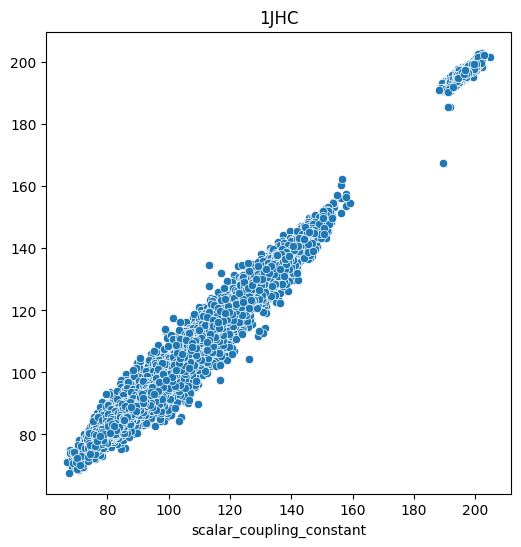

training model for type: 1JHN...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's l2: 0.497585	valid_0's mae: 0.459876
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's l2: 1.41759	valid_0's mae: 0.836086
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 1.78896	valid_0's mae: 0.961678
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[330]	valid_0's l2: 0.633114	valid_0's mae: 0.548696
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[750]	valid_0's l2: 1.08809	valid_0's mae: 0.739409
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[530]	valid_0's l2: 0.893672	valid_0's mae: 0.65424

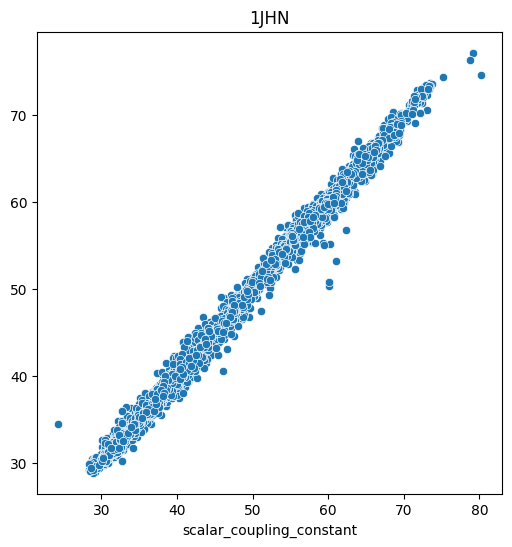

training model for type: 2JHC...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[940]	valid_0's l2: 0.89334	valid_0's mae: 0.617664
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[340]	valid_0's l2: 2.35846	valid_0's mae: 1.04233
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[650]	valid_0's l2: 0.671199	valid_0's mae: 0.524619
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[890]	valid_0's l2: 1.34199	valid_0's mae: 0.768198
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[830]	valid_0's l2: 1.75637	valid_0's mae: 0.894582
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[350]	valid_0's l2: 1.21285	valid_0's mae: 0.732363
T

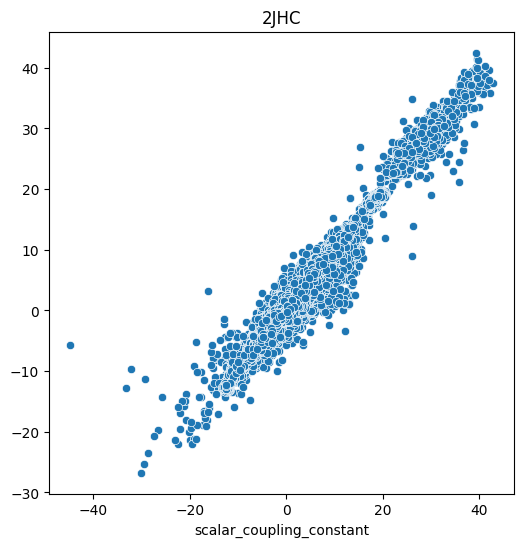

training model for type: 2JHH...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[700]	valid_0's l2: 0.352084	valid_0's mae: 0.383377
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[210]	valid_0's l2: 0.737132	valid_0's mae: 0.579062
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's l2: 0.670359	valid_0's mae: 0.529497
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[350]	valid_0's l2: 1.09752	valid_0's mae: 0.692958
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.277814	valid_0's mae: 0.336427
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[830]	valid_0's l2: 0.192705	valid_0's mae: 0.276

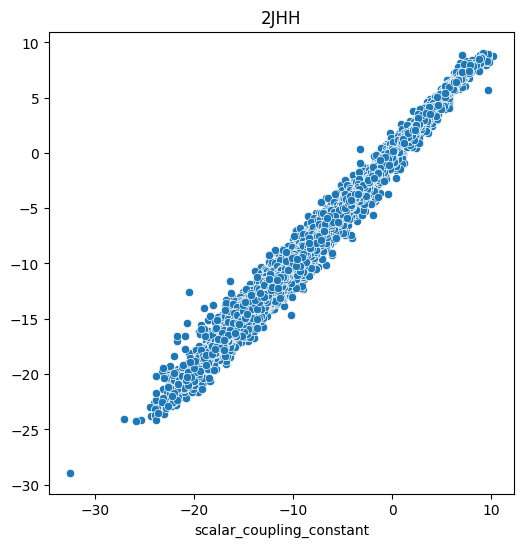

training model for type: 2JHN...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's l2: 0.586256	valid_0's mae: 0.502761
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[650]	valid_0's l2: 0.804805	valid_0's mae: 0.618326
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[930]	valid_0's l2: 0.379265	valid_0's mae: 0.373472
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[560]	valid_0's l2: 0.404755	valid_0's mae: 0.397635
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[410]	valid_0's l2: 0.433366	valid_0's mae: 0.418848
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[740]	valid_0's l2: 0.498753	valid_0's mae: 0.44

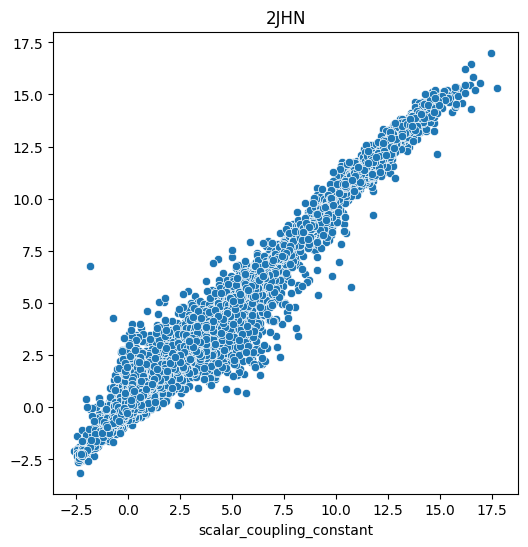

training model for type: 3JHC...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[610]	valid_0's l2: 1.07137	valid_0's mae: 0.700384
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[720]	valid_0's l2: 1.33499	valid_0's mae: 0.783756
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[690]	valid_0's l2: 1.83396	valid_0's mae: 0.928381
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[690]	valid_0's l2: 3.50096	valid_0's mae: 1.31313
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[650]	valid_0's l2: 1.65212	valid_0's mae: 0.870436
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[840]	valid_0's l2: 3.40301	valid_0's mae: 1.29164
Tra

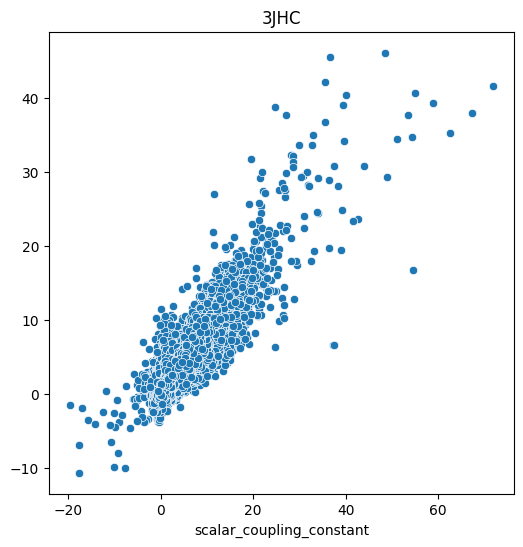

training model for type: 3JHH...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 0.908641	valid_0's mae: 0.691179
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[660]	valid_0's l2: 2.07925	valid_0's mae: 1.0814
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's l2: 0.800323	valid_0's mae: 0.640654
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[430]	valid_0's l2: 0.537883	valid_0's mae: 0.511947
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[590]	valid_0's l2: 0.530671	valid_0's mae: 0.511895
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[390]	valid_0's l2: 0.638528	valid_0's mae: 0.56099

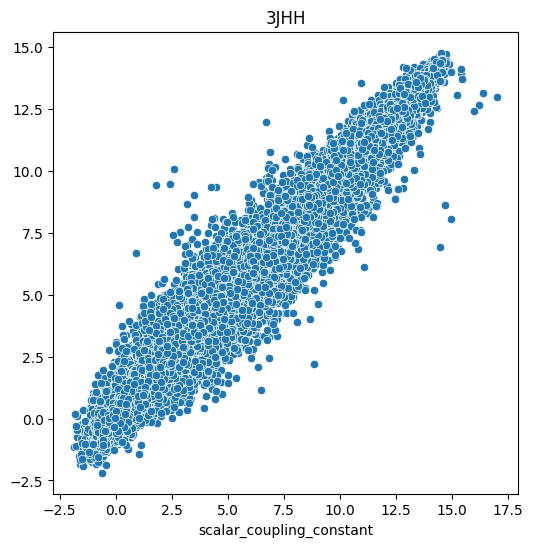

training model for type: 3JHN...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[870]	valid_0's l2: 0.259912	valid_0's mae: 0.328696
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[780]	valid_0's l2: 0.156275	valid_0's mae: 0.24995
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[170]	valid_0's l2: 0.59089	valid_0's mae: 0.526757
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[750]	valid_0's l2: 0.127044	valid_0's mae: 0.222521
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[940]	valid_0's l2: 0.238822	valid_0's mae: 0.315728
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[650]	valid_0's l2: 0.227519	valid_0's mae: 0.3038

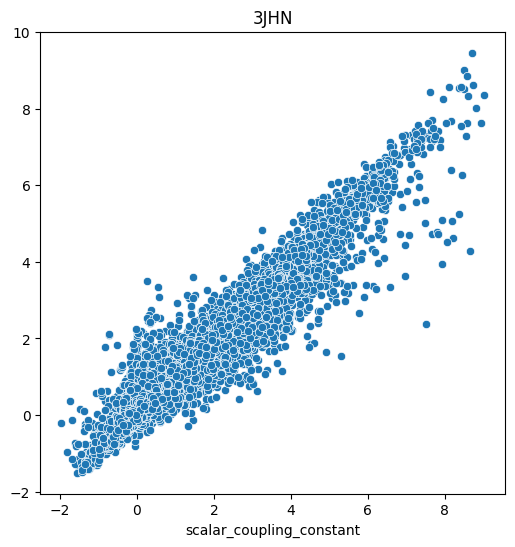

In [45]:
lgbm_val_lmae, lgbm_train_lmae, lgbm_val_y, lgbm_val_pred_y = {}, {}, {}, {}


for j_type in types:
  X = train[train['type'] == j_type].drop(columns=['scalar_coupling_constant', 'type', 'id'])
  y = train[train['type'] == j_type]['scalar_coupling_constant']
  print(f'training model for type: {j_type}...')
  lgbm_train_lmae[j_type], lgbm_val_lmae[j_type], lgbm_val_y[j_type], lgbm_val_pred_y[j_type] = lgbm_model(X, y, j_type)

  plt.figure(figsize=[6,6])
  sns.scatterplot(x=lgbm_val_y[j_type], y=lgbm_val_pred_y[j_type])
  plt.title(j_type)
  plt.show()

In [ ]:
pprint(lgbm_val_lmae)
pprint(lgbm_train_lmae)